In [1]:
import argparse
import json
import numpy as np
import time
import os
import shutil
import psutil
import sys
import socket
import traceback

from collections import OrderedDict

import torch
from torch.utils.data import DataLoader

import robomimic
import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.config import config_factory
from robomimic.algo import algo_factory, RolloutPolicy
from robomimic.utils.log_utils import PrintLogger, DataLogger, flush_warnings

import matplotlib.pyplot as plt

import os

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/carl/robomimic/robomimic/scripts/setup_macros.py
)


In [2]:
dir="/home/carl/data_sawyer/models/"
fn="model_epoch_600.pth"
ckpt_path=dir+fn
assert os.path.exists(ckpt_path)

In [3]:
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=True)
pass 

============= Loaded Config =============
{
    "algo_name": "bc",
    "experiment": {
        "name": "sawyer_block",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": false,
            "wandb_proj_name": "block"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 20,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 500,
        "validation_epoch_every_n_steps": 50,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_videos": false,
        "video_skip": 5,
        "rollout": {
            "enabled": false,
            "n": 50,
            "horizon": 1000,
            "rate": 20,
            "w

/home/carl/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carl/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


============= Loaded Policy =============
ObservationKeyToModalityDict: mean not found, adding mean to mapping with assumed low_dim modality!
ObservationKeyToModalityDict: scale not found, adding scale to mapping with assumed low_dim modality!
ObservationKeyToModalityDict: logits not found, adding logits to mapping with assumed low_dim modality!
BC_RNN_GMM (
  ModuleDict(
    (policy): RNNGMMActorNetwork(
        action_dim=7, std_activation=softplus, low_noise_eval=True, num_nodes=5, min_std=0.0001
  
        encoder=ObservationGroupEncoder(
            group=obs
            ObservationEncoder(
                Key(
                    name=agentview_image
                    shape=[3, 84, 84]
                    modality=rgb
                    randomizer=CropRandomizer(input_shape=[3, 84, 84], crop_size=[76, 76], num_crops=1)
                    net=VisualCore(
                      input_shape=[3, 76, 76]
                      output_shape=[64]
                      backbone_net=Res

In [4]:

ckpt_dict = FileUtils.maybe_dict_from_checkpoint(ckpt_path=ckpt_path, ckpt_dict=None)
# algo name and config from model dict
algo_name, _ = FileUtils.algo_name_from_checkpoint(ckpt_dict=ckpt_dict)
config, _ = FileUtils.config_from_checkpoint(algo_name=algo_name, ckpt_dict=ckpt_dict, verbose=False)

In [9]:
config.unlock()
config.train.data="/home/carl/data_sawyer/block/demos.hdf5"
config.lock()

In [10]:
ObsUtils.initialize_obs_utils_with_config(config)
dataset_path = os.path.expanduser(config.train.data)
shape_meta = FileUtils.get_shape_metadata_from_dataset(
    dataset_path=config.train.data,
    all_obs_keys=config.all_obs_keys,
    verbose=True
)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_pos']
using obs modality: rgb with keys: ['agentview_image', 'robot0_eye_in_hand_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
obs key agentview_image with shape (84, 84, 3)
obs key robot0_eef_pos with shape (6,)
obs key robot0_eye_in_hand_image with shape (84, 84, 3)


In [11]:
trainset, validset = TrainUtils.load_data_for_training(
    config, obs_keys=shape_meta["all_obs_keys"])
len(trainset.demos)

SequenceDataset: loading dataset into memory...
100%|██████████| 25/25 [00:00<00:00, 2184.44it/s]


25

In [12]:
batch=trainset.get_trajectory_at_index(0)
batch.keys()

dict_keys(['actions', 'rewards', 'dones', 'obs', 'ep'])

In [13]:
ob = policy._prepare_observation(batch['obs'])

In [14]:
ob.keys()

dict_keys(['agentview_image', 'robot0_eef_pos', 'robot0_eye_in_hand_image'])

In [15]:
def demo2actions(hdf5_file, demo_key, rollout_policy): 
    rollout_policy.start_episode()


    demo=hdf5_file['data'][demo_key]
    actions_real=demo['actions']
    obs=demo['obs']
    N=obs['robot0_eye_in_hand_image'].shape[0]

    obss=[]
    for i in range(N):
        ob={k:obs[k][i] for k in obs.keys()} 
        ob['robot0_eye_in_hand_image']=ob['robot0_eye_in_hand_image'].transpose(2,0,1)
        ob['agentview_image']=ob['agentview_image'].transpose(2,0,1)
        obss.append(ob)

    acs=[]
    for ob in obss: 
        ob = rollout_policy._prepare_observation(ob)
        ac = rollout_policy.policy.get_action(obs_dict=ob, goal_dict=None)
        ac=ac.detach().cpu().numpy()[0]
        acs.append(ac)

    actions_pred=np.array(acs)
    return actions_real, actions_pred

In [16]:
file=trainset.hdf5_file
demo_key="demo_1"
actions_real, actions_pred=demo2actions(file, demo_key, policy)
actions_real.shape, actions_pred.shape

/home/carl/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


((150, 7), (150, 7))

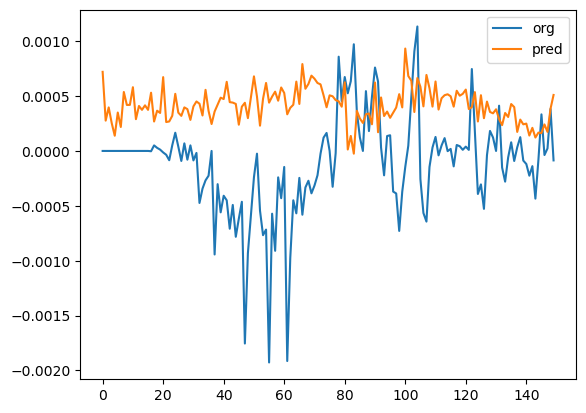

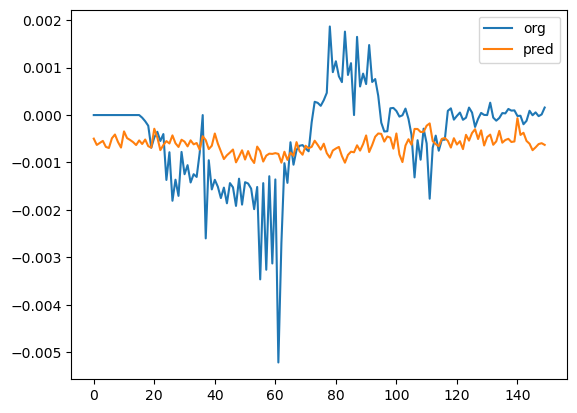

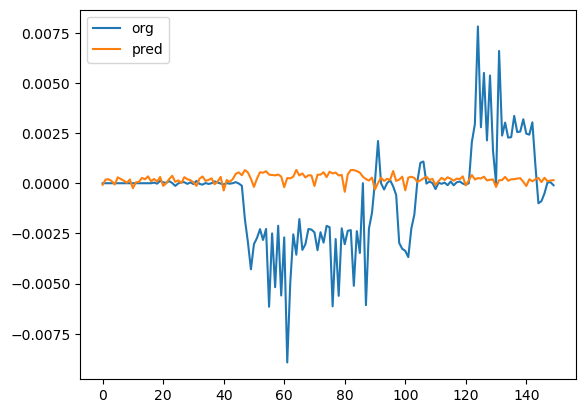

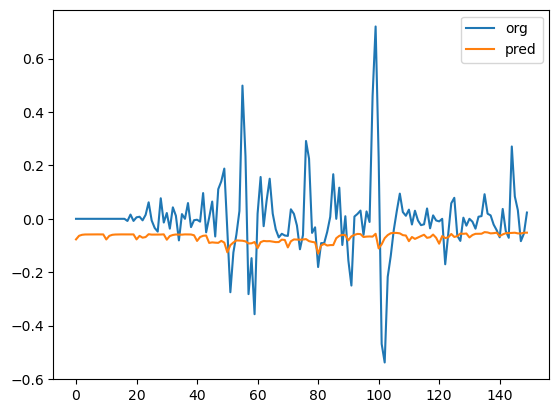

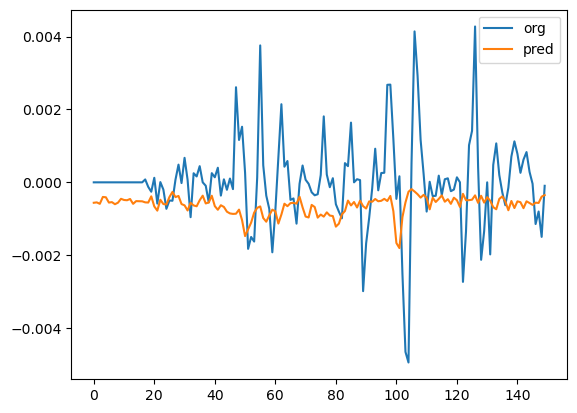

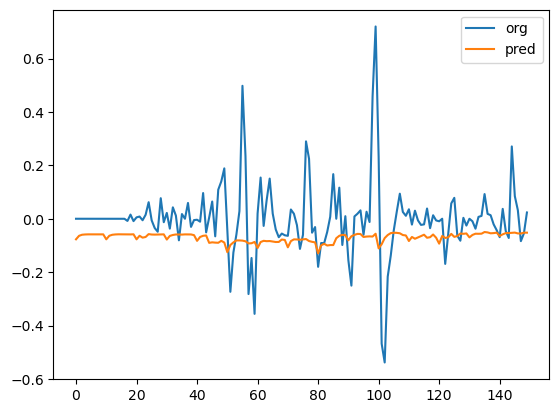

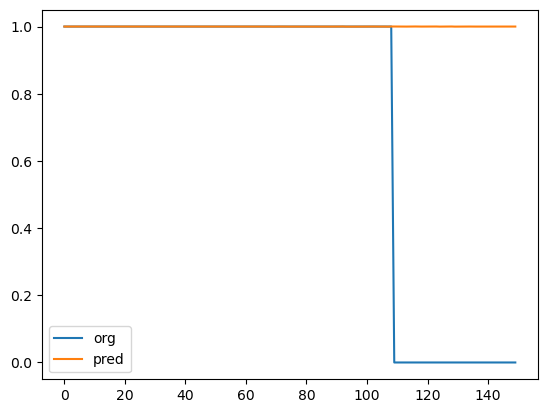

In [17]:
for i in range(7):
    plt.plot(actions_real[:,i], label='org')
    plt.plot(actions_pred[:,i], label='pred')
    plt.legend()
    plt.show()